#Part One − Model Training with Cross Entropy Loss

(a) Model Setup

We will use a pre-trained ResNet-50 model and modify it for our two-class classification problem (airplane and automobile).

In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import copy

# Check if CUDA is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda:0


In [2]:
# Classes we are interested in
classes = ('airplane', 'automobile')
classes_to_include = [0, 1]  # CIFAR-10 labels for airplane and automobile

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to match ResNet input size
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],   # Normalize to match ImageNet statistics
                         [0.229, 0.224, 0.225])
])

# Download the CIFAR-10 dataset
train_dataset_full = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                  download=True)
test_dataset_full = torchvision.datasets.CIFAR10(root='./data', train=False,
                                                 download=True)

100%|██████████| 170M/170M [00:18<00:00, 9.08MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
from torch.utils.data import Dataset, DataLoader

class CIFAR10TwoClass(Dataset):
    def __init__(self, dataset, classes_to_include, transform=None):
        self.transform = transform
        self.classes_to_include = classes_to_include

        self.data = []
        self.targets = []

        for idx in range(len(dataset)):
            img, label = dataset.data[idx], dataset.targets[idx]
            if label in classes_to_include:
                self.data.append(img)
                self.targets.append(classes_to_include.index(label))  # remap labels to 0 and 1

        self.data = np.array(self.data)
        self.targets = np.array(self.targets)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.targets[idx]
        img = Image.fromarray(img)
        if self.transform:
            img = self.transform(img)
        return img, label

from PIL import Image

# Create training and testing datasets
train_dataset = CIFAR10TwoClass(train_dataset_full, classes_to_include=[0, 1], transform=transform)
test_dataset = CIFAR10TwoClass(test_dataset_full, classes_to_include=[0, 1], transform=transform)

# Create data loaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [4]:
# Load pre-trained ResNet-50 model
model = models.resnet50(pretrained=True)

# Modify the final fully connected layer to output two classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Two classes: airplane and automobile

model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 189MB/s]


(b) Training the Model with Cross Entropy Loss

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [6]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=10):
    since = time.time()

    train_losses = []
    train_accuracies = []
    val_accuracies = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Loop over epochs
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Training mode
                dataloader = dataloaders['train']
            else:
                model.eval()   # Evaluation mode
                dataloader = dataloaders['val']

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass and optimization
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # Calculate epoch loss and accuracy
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            epoch_acc = epoch_acc.item()

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc)
            else:
                val_accuracies.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase.capitalize(), epoch_loss, epoch_acc))

            # Deep copy the model if it has better accuracy
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    # Training complete
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best Validation Accuracy: {:4f}'.format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)

    return model, train_losses, train_accuracies, val_accuracies

In [7]:
dataloaders = {'train': train_loader, 'val': test_loader}
num_epochs = 10
model, train_losses, train_accuracies, val_accuracies = train_model(
    model, dataloaders, criterion, optimizer, num_epochs=num_epochs)



Epoch 1/10
----------
Train Loss: 0.1112 Acc: 0.9580
Val Loss: 0.0248 Acc: 0.9940

Epoch 2/10
----------
Train Loss: 0.0195 Acc: 0.9933
Val Loss: 0.0155 Acc: 0.9955

Epoch 3/10
----------
Train Loss: 0.0082 Acc: 0.9979
Val Loss: 0.0099 Acc: 0.9970

Epoch 4/10
----------
Train Loss: 0.0067 Acc: 0.9985
Val Loss: 0.0110 Acc: 0.9965

Epoch 5/10
----------
Train Loss: 0.0061 Acc: 0.9982
Val Loss: 0.0131 Acc: 0.9960

Epoch 6/10
----------
Train Loss: 0.0026 Acc: 0.9996
Val Loss: 0.0086 Acc: 0.9975

Epoch 7/10
----------
Train Loss: 0.0025 Acc: 0.9994
Val Loss: 0.0111 Acc: 0.9970

Epoch 8/10
----------
Train Loss: 0.0013 Acc: 0.9999
Val Loss: 0.0100 Acc: 0.9960

Epoch 9/10
----------
Train Loss: 0.0014 Acc: 0.9999
Val Loss: 0.0108 Acc: 0.9965

Epoch 10/10
----------
Train Loss: 0.0018 Acc: 0.9996
Val Loss: 0.0124 Acc: 0.9955

Training complete in 17m 40s
Best Validation Accuracy: 0.997500


(c) Plotting Accuracy and Loss Graphs

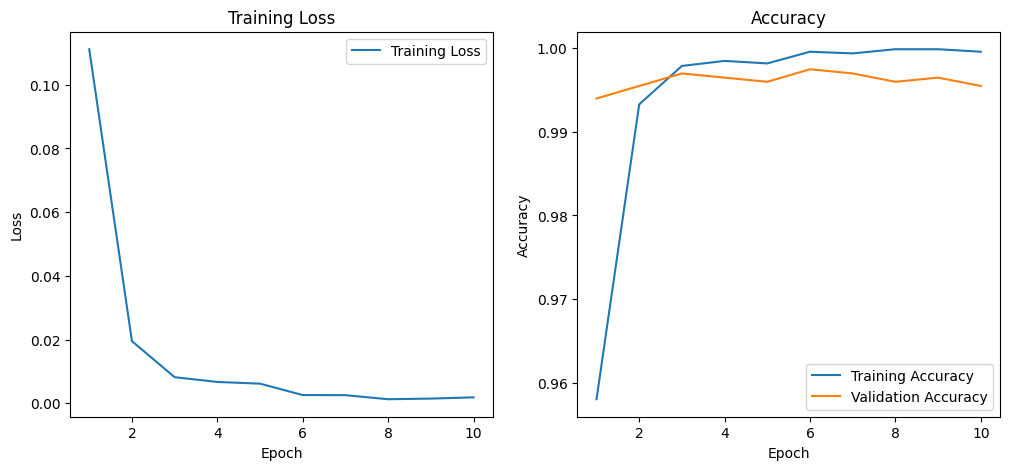

In [8]:
# Plot Loss and Accuracy graphs
epochs = range(1, num_epochs+1)

plt.figure(figsize=(12, 5))

# Loss graph
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Accuracy graph
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()

(d) Extracting and Displaying Feature Maps

In [9]:
# Function to store activations
activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# Register hooks to the desired layers
model.conv1.register_forward_hook(get_activation('conv1'))
model.layer1.register_forward_hook(get_activation('layer1'))
model.layer2.register_forward_hook(get_activation('layer2'))
model.layer3.register_forward_hook(get_activation('layer3'))
model.layer4.register_forward_hook(get_activation('layer4'))

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)
inputs = images.to(device)

# Forward pass through the model
output = model(inputs)

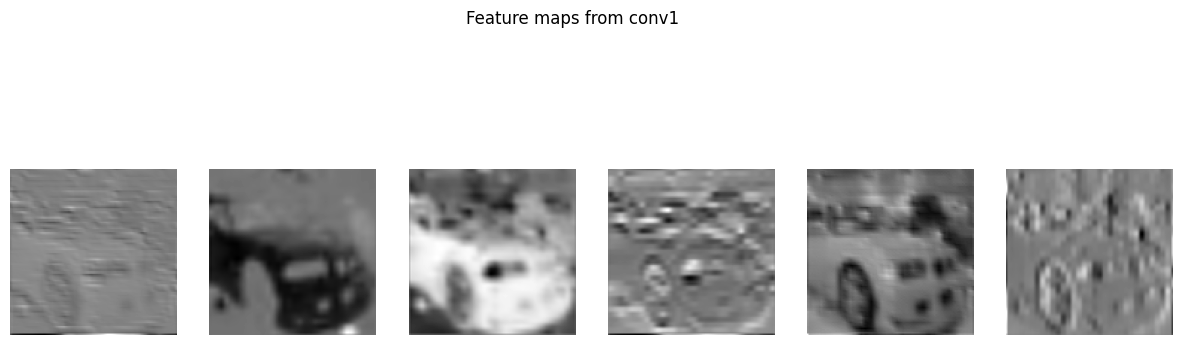

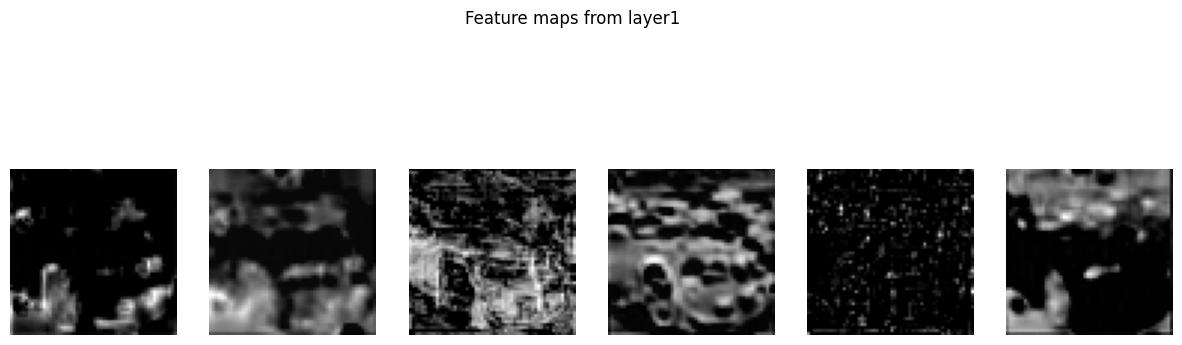

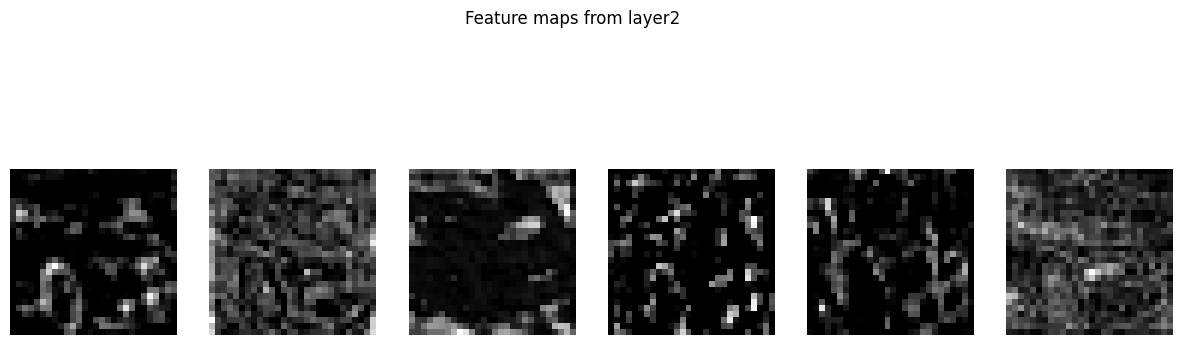

In [10]:
def visualize_feature_maps(activation, layer_name, image_idx=0, num_feature_maps=6):
    feature_maps = activation[layer_name].cpu()[image_idx]
    num_channels = feature_maps.shape[0]
    plt.figure(figsize=(15, 5))
    for i in range(num_feature_maps):
        if i >= num_channels:
            break
        plt.subplot(1, num_feature_maps, i+1)
        plt.imshow(feature_maps[i].detach().numpy(), cmap='gray')
        plt.axis('off')
    plt.suptitle(f'Feature maps from {layer_name}')
    plt.show()

# Visualize feature maps from different layers
visualize_feature_maps(activation, 'conv1')
visualize_feature_maps(activation, 'layer1')
visualize_feature_maps(activation, 'layer2')

#Part Two − Model Training with Triplet Loss Criterion


(a) Creating a Custom Triplet Dataset

In [11]:
class TripletCIFAR10(Dataset):
    def __init__(self, dataset, classes_to_include, transform=None):
        self.transform = transform
        self.classes_to_include = classes_to_include

        # Prepare data and targets
        self.data = []
        self.targets = []

        for idx in range(len(dataset)):
            img, label = dataset.data[idx], dataset.targets[idx]
            if label in classes_to_include:
                self.data.append(img)
                self.targets.append(classes_to_include.index(label))  # Remap labels to 0 and 1

        self.data = np.array(self.data)
        self.targets = np.array(self.targets)

        # Build a dictionary to map labels to indices
        self.label_to_indices = {label: np.where(self.targets == label)[0]
                                 for label in set(self.targets)}

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        anchor_img = self.data[idx]
        anchor_label = self.targets[idx]

        # Select a positive sample
        positive_idx = idx
        while positive_idx == idx:
            positive_idx = np.random.choice(self.label_to_indices[anchor_label])
        positive_img = self.data[positive_idx]

        # Select a negative sample
        negative_label = (anchor_label + 1) % 2  # Since we have only 2 classes
        negative_idx = np.random.choice(self.label_to_indices[negative_label])
        negative_img = self.data[negative_idx]

        # Transform images
        anchor_img = Image.fromarray(anchor_img)
        positive_img = Image.fromarray(positive_img)
        negative_img = Image.fromarray(negative_img)

        if self.transform:
            anchor_img = self.transform(anchor_img)
            positive_img = self.transform(positive_img)
            negative_img = self.transform(negative_img)

        return (anchor_img, positive_img, negative_img), []

# Create the triplet dataset and data loader
train_dataset_triplet = TripletCIFAR10(train_dataset_full, classes_to_include=[0, 1], transform=transform)
train_loader_triplet = DataLoader(train_dataset_triplet, batch_size=batch_size, shuffle=True, num_workers=2)

(b) Training the Feature Extractor with Triplet Loss

In [12]:
# Create a feature extractor model
class ResNet50Triplet(nn.Module):
    def __init__(self, pretrained=True):
        super(ResNet50Triplet, self).__init__()
        self.model = models.resnet50(pretrained=pretrained)
        self.model.fc = nn.Identity()  # Remove the last fully connected layer

    def forward(self, x):
        x = self.model(x)
        return x

# Instantiate the model
model_triplet = ResNet50Triplet(pretrained=True)
model_triplet = model_triplet.to(device)

In [13]:
triplet_criterion = nn.TripletMarginLoss(margin=1.0, p=2)
optimizer_triplet = optim.SGD(model_triplet.parameters(), lr=0.001, momentum=0.9)

In [14]:
def train_triplet_model(model, dataloader, criterion, optimizer, num_epochs=10):
    since = time.time()

    train_losses = []

    model.train()  # Set model to training mode

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        running_loss = 0.0

        # Iterate over data
        for data in dataloader:
            (anchor_img, positive_img, negative_img), _ = data
            anchor_img = anchor_img.to(device)
            positive_img = positive_img.to(device)
            negative_img = negative_img.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            anchor_output = model(anchor_img)
            positive_output = model(positive_img)
            negative_output = model(negative_img)

            loss = criterion(anchor_output, positive_output, negative_output)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item() * anchor_img.size(0)

        epoch_loss = running_loss / len(dataloader.dataset)
        train_losses.append(epoch_loss)

        print('Loss: {:.4f}'.format(epoch_loss))

    # Training complete
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    return model, train_losses

In [15]:
num_epochs = 10
model_triplet, train_losses_triplet = train_triplet_model(
    model_triplet, train_loader_triplet, triplet_criterion, optimizer_triplet, num_epochs=num_epochs)

Epoch 1/10
----------
Loss: 0.2018
Epoch 2/10
----------
Loss: 0.0594
Epoch 3/10
----------
Loss: 0.0411
Epoch 4/10
----------
Loss: 0.0219
Epoch 5/10
----------
Loss: 0.0201
Epoch 6/10
----------
Loss: 0.0090
Epoch 7/10
----------
Loss: 0.0103
Epoch 8/10
----------
Loss: 0.0090
Epoch 9/10
----------
Loss: 0.0068
Epoch 10/10
----------
Loss: 0.0049
Training complete in 47m 15s


Freezing the Feature Extractor and Training the Classifier



In [16]:
class ResNet50Classifier(nn.Module):
    def __init__(self, feature_extractor):
        super(ResNet50Classifier, self).__init__()
        self.feature_extractor = feature_extractor.model  # Include all layers except the final fc layer
        # Freeze the feature extractor
        for param in self.feature_extractor.parameters():
            param.requires_grad = False
        # Add a new fully connected layer
        self.fc = nn.Linear(2048, 2)  # Output size is 2 classes

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.fc(x)
        return x

# Instantiate the model
model_classifier = ResNet50Classifier(model_triplet)
model_classifier = model_classifier.to(device)

In [17]:
criterion_classifier = nn.CrossEntropyLoss()
optimizer_classifier = optim.SGD(model_classifier.fc.parameters(), lr=0.001, momentum=0.9)

In [18]:
num_epochs = 10
model_classifier, train_losses_classifier, train_accuracies_classifier, val_accuracies_classifier = train_model(
    model_classifier, dataloaders, criterion_classifier, optimizer_classifier, num_epochs=num_epochs)

Epoch 1/10
----------
Train Loss: 0.0167 Acc: 0.9982
Val Loss: 0.0100 Acc: 0.9975

Epoch 2/10
----------
Train Loss: 0.0038 Acc: 0.9993
Val Loss: 0.0091 Acc: 0.9965

Epoch 3/10
----------
Train Loss: 0.0037 Acc: 0.9993
Val Loss: 0.0084 Acc: 0.9965

Epoch 4/10
----------
Train Loss: 0.0026 Acc: 0.9994
Val Loss: 0.0083 Acc: 0.9970

Epoch 5/10
----------
Train Loss: 0.0022 Acc: 0.9995
Val Loss: 0.0088 Acc: 0.9970

Epoch 6/10
----------
Train Loss: 0.0025 Acc: 0.9996
Val Loss: 0.0087 Acc: 0.9970

Epoch 7/10
----------
Train Loss: 0.0024 Acc: 0.9994
Val Loss: 0.0082 Acc: 0.9970

Epoch 8/10
----------
Train Loss: 0.0015 Acc: 0.9998
Val Loss: 0.0105 Acc: 0.9960

Epoch 9/10
----------
Train Loss: 0.0029 Acc: 0.9987
Val Loss: 0.0093 Acc: 0.9970

Epoch 10/10
----------
Train Loss: 0.0013 Acc: 0.9998
Val Loss: 0.0084 Acc: 0.9965

Training complete in 7m 0s
Best Validation Accuracy: 0.997500


(c) Plotting Graphs and Calculating Final Accuracy

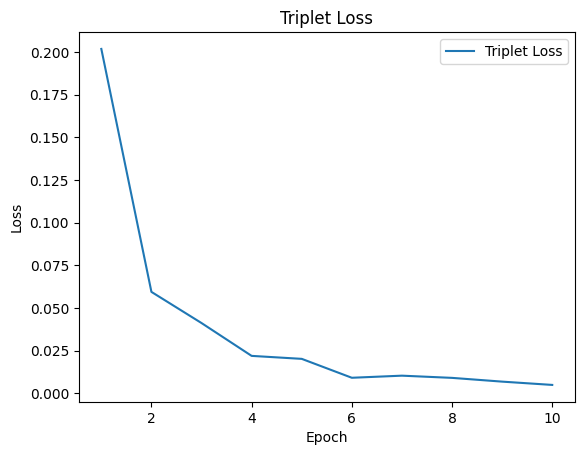

In [19]:
# Plot Triplet Loss over epochs
epochs = range(1, num_epochs+1)

plt.figure()
plt.plot(epochs, train_losses_triplet, label='Triplet Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Triplet Loss')
plt.legend()
plt.show()

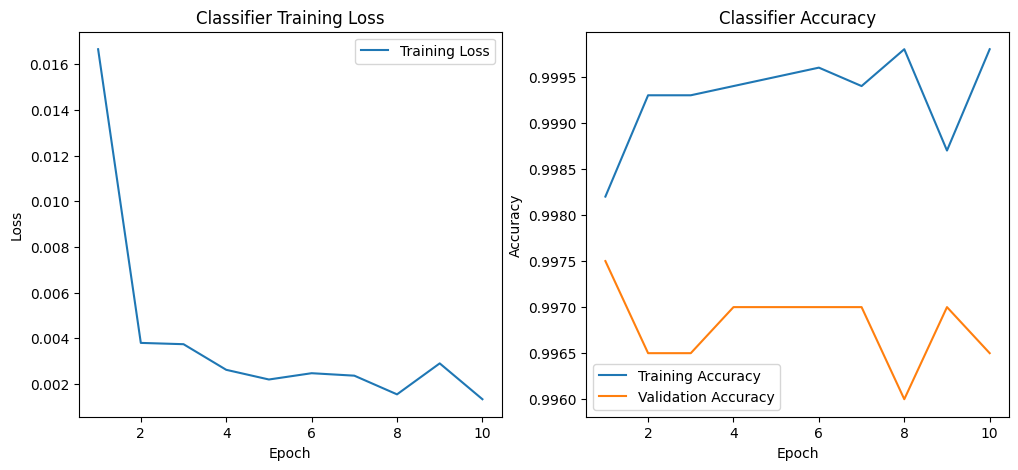

In [20]:
# Plot Loss and Accuracy graphs for classifier training
epochs = range(1, num_epochs+1)

plt.figure(figsize=(12, 5))

# Loss graph
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses_classifier, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Classifier Training Loss')
plt.legend()

# Accuracy graph
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies_classifier, label='Training Accuracy')
plt.plot(epochs, val_accuracies_classifier, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Classifier Accuracy')
plt.legend()

plt.show()

In [21]:
def evaluate_model(model, dataloader):
    model.eval()
    running_corrects = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            running_corrects += torch.sum(preds == labels.data)
            total += labels.size(0)

    accuracy = running_corrects.double() / total
    print('Test Accuracy: {:.4f}'.format(accuracy))
    return accuracy

test_accuracy = evaluate_model(model_classifier, test_loader)

Test Accuracy: 0.9975


(d) Examining and Analyzing Feature Maps

In [22]:
# Function to store activations
activation = {}

# Register hooks to the desired layers
model_classifier.feature_extractor.conv1.register_forward_hook(get_activation('conv1'))
model_classifier.feature_extractor.layer1.register_forward_hook(get_activation('layer1'))
model_classifier.feature_extractor.layer2.register_forward_hook(get_activation('layer2'))
model_classifier.feature_extractor.layer3.register_forward_hook(get_activation('layer3'))
model_classifier.feature_extractor.layer4.register_forward_hook(get_activation('layer4'))

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)
inputs = images.to(device)

# Forward pass through the model
output = model_classifier(inputs)

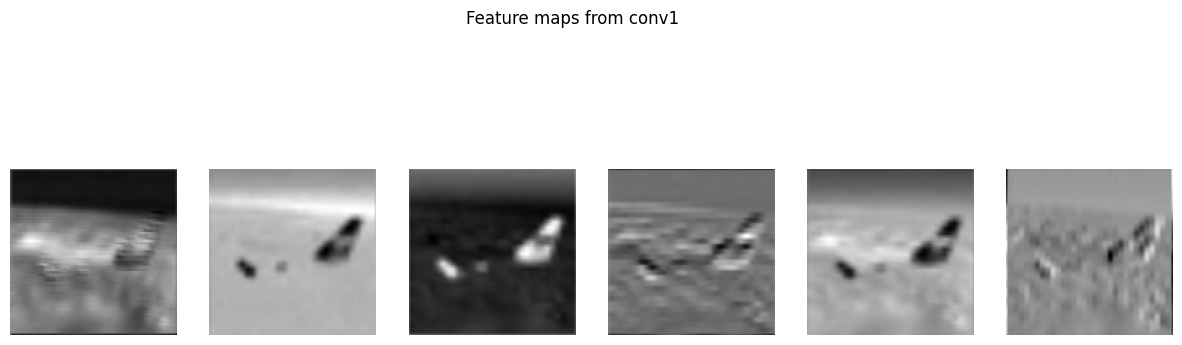

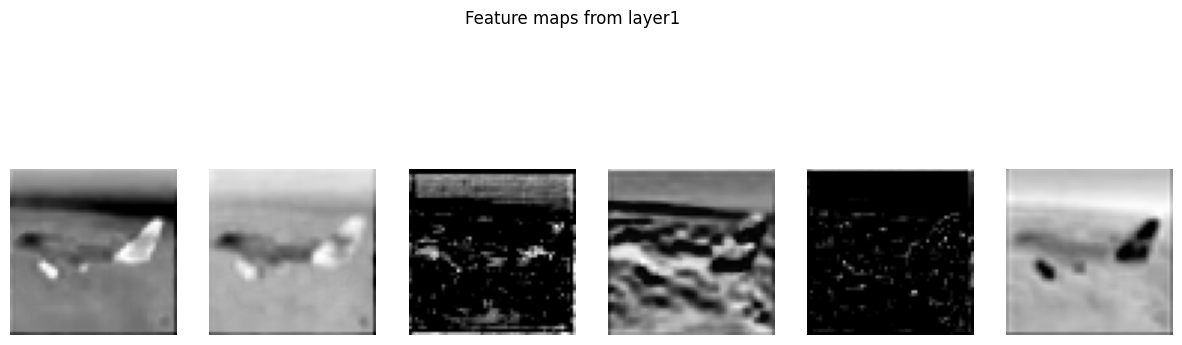

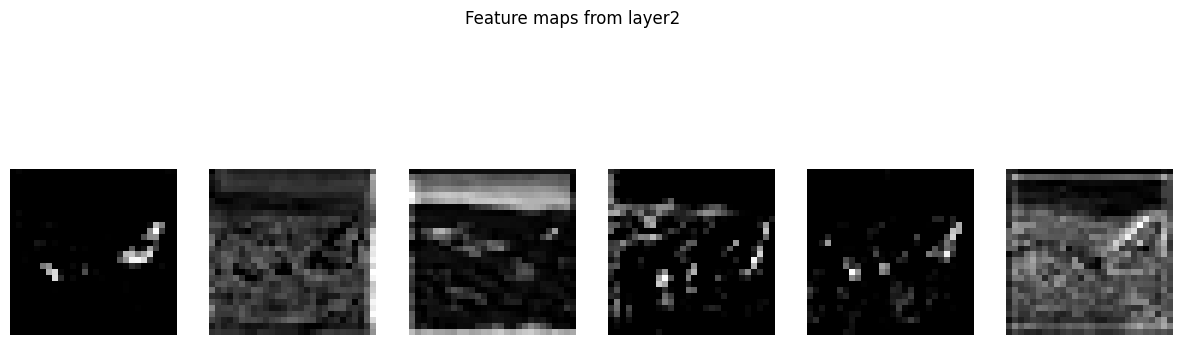

In [23]:
# Visualize feature maps from different layers
visualize_feature_maps(activation, 'conv1')
visualize_feature_maps(activation, 'layer1')
visualize_feature_maps(activation, 'layer2')

#Part Three − Comparison and Conclusion

Analysis:

Feature Map Quality: By comparing the feature maps from Part One and Part Two, we can observe differences in how the network processes inputs. Training with triplet loss may result in more discriminative feature maps that better separate the two classes.

Final Accuracy: Compare the test accuracies obtained in both parts. The model trained with triplet loss may show improved generalization.

Convergence Speed: Training with cross-entropy loss may converge faster than training with triplet loss due to the complexity of learning embeddings.

Conclusion:

Cross Entropy Loss: Suitable for straightforward classification tasks with clear class boundaries.

Triplet Loss: Beneficial when the goal is to learn embeddings for tasks like face recognition or retrieval, where distinguishing between subtle differences is crucial.


#Part Four − Combining Loss Criterion Functions

(a) Training the Entire Model with Combined Loss

In [24]:
class ResNet50Combined(nn.Module):
    def __init__(self, pretrained=True):
        super(ResNet50Combined, self).__init__()
        self.feature_extractor = models.resnet50(pretrained=pretrained)
        num_ftrs = self.feature_extractor.fc.in_features
        self.feature_extractor.fc = nn.Identity()  # Remove the last fully connected layer
        self.classifier = nn.Linear(num_ftrs, 2)  # For classification

    def forward(self, x):
        x = self.feature_extractor(x)
        embeddings = x
        class_outputs = self.classifier(x)
        return embeddings, class_outputs

# Instantiate the model
model_combined = ResNet50Combined(pretrained=True)
model_combined = model_combined.to(device)

In [25]:
class TripletCIFAR10Combined(Dataset):
    def __init__(self, dataset, classes_to_include, transform=None):
        self.transform = transform
        self.classes_to_include = classes_to_include

        self.data = []
        self.targets = []

        for idx in range(len(dataset)):
            img, label = dataset.data[idx], dataset.targets[idx]
            if label in classes_to_include:
                self.data.append(img)
                self.targets.append(classes_to_include.index(label))  # Remap labels to 0 and 1

        self.data = np.array(self.data)
        self.targets = np.array(self.targets)

        self.label_to_indices = {label: np.where(self.targets == label)[0]
                                 for label in set(self.targets)}

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        anchor_img = self.data[idx]
        anchor_label = self.targets[idx]

        # Select a positive sample
        positive_idx = idx
        while positive_idx == idx:
            positive_idx = np.random.choice(self.label_to_indices[anchor_label])
        positive_img = self.data[positive_idx]

        # Select a negative sample
        negative_label = (anchor_label + 1) % 2  # Since we have only 2 classes
        negative_idx = np.random.choice(self.label_to_indices[negative_label])
        negative_img = self.data[negative_idx]

        # Transform images
        anchor_img = Image.fromarray(anchor_img)
        positive_img = Image.fromarray(positive_img)
        negative_img = Image.fromarray(negative_img)

        if self.transform:
            anchor_img = self.transform(anchor_img)
            positive_img = self.transform(positive_img)
            negative_img = self.transform(negative_img)

        return (anchor_img, positive_img, negative_img), anchor_label

# Create the combined dataset and data loader
train_dataset_combined = TripletCIFAR10Combined(train_dataset_full, classes_to_include=[0, 1], transform=transform)
train_loader_combined = DataLoader(train_dataset_combined, batch_size=batch_size, shuffle=True, num_workers=2)

In [26]:
triplet_criterion = nn.TripletMarginLoss(margin=1.0, p=2)
cross_entropy_criterion = nn.CrossEntropyLoss()
optimizer_combined = optim.SGD(model_combined.parameters(), lr=0.001, momentum=0.9)

In [27]:
def train_combined_model(model, dataloader, triplet_criterion, cross_entropy_criterion, optimizer, num_epochs=10):
    since = time.time()

    total_losses = []
    triplet_losses = []
    cross_entropy_losses = []
    train_accuracies = []

    model.train()  # Set model to training mode

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        running_loss = 0.0
        running_triplet_loss = 0.0
        running_ce_loss = 0.0
        running_corrects = 0
        total_samples = 0

        # Iterate over data
        for data in dataloader:
            (anchor_img, positive_img, negative_img), labels = data
            anchor_img = anchor_img.to(device)
            positive_img = positive_img.to(device)
            negative_img = negative_img.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            anchor_embeddings, anchor_outputs = model(anchor_img)
            positive_embeddings, _ = model(positive_img)
            negative_embeddings, _ = model(negative_img)

            triplet_loss = triplet_criterion(anchor_embeddings, positive_embeddings, negative_embeddings)
            ce_loss = cross_entropy_criterion(anchor_outputs, labels)

            total_loss = triplet_loss + ce_loss

            # Backward pass and optimization
            total_loss.backward()
            optimizer.step()

            # Statistics
            running_loss += total_loss.item() * anchor_img.size(0)
            running_triplet_loss += triplet_loss.item() * anchor_img.size(0)
            running_ce_loss += ce_loss.item() * anchor_img.size(0)

            _, preds = torch.max(anchor_outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
            total_samples += labels.size(0)

        # Calculate epoch losses and accuracy
        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_triplet_loss = running_triplet_loss / len(dataloader.dataset)
        epoch_ce_loss = running_ce_loss / len(dataloader.dataset)
        epoch_acc = running_corrects.double() / total_samples
        epoch_acc = epoch_acc.item()

        total_losses.append(epoch_loss)
        triplet_losses.append(epoch_triplet_loss)
        cross_entropy_losses.append(epoch_ce_loss)
        train_accuracies.append(epoch_acc)

        print('Loss: {:.4f} Triplet Loss: {:.4f} CE Loss: {:.4f} Acc: {:.4f}'.format(
            epoch_loss, epoch_triplet_loss, epoch_ce_loss, epoch_acc))

    # Training complete
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    return model, total_losses, triplet_losses, cross_entropy_losses, train_accuracies

In [28]:
num_epochs = 10
model_combined, total_losses_combined, triplet_losses_combined, cross_entropy_losses_combined, train_accuracies_combined = train_combined_model(
    model_combined, train_loader_combined, triplet_criterion, cross_entropy_criterion, optimizer_combined, num_epochs=num_epochs)

Epoch 1/10
----------
Loss: 0.2529 Triplet Loss: 0.1637 CE Loss: 0.0892 Acc: 0.9658
Epoch 2/10
----------
Loss: 0.0605 Triplet Loss: 0.0398 CE Loss: 0.0207 Acc: 0.9933
Epoch 3/10
----------
Loss: 0.0338 Triplet Loss: 0.0218 CE Loss: 0.0120 Acc: 0.9964
Epoch 4/10
----------
Loss: 0.0300 Triplet Loss: 0.0193 CE Loss: 0.0107 Acc: 0.9970
Epoch 5/10
----------
Loss: 0.0148 Triplet Loss: 0.0092 CE Loss: 0.0056 Acc: 0.9988
Epoch 6/10
----------
Loss: 0.0169 Triplet Loss: 0.0115 CE Loss: 0.0054 Acc: 0.9980
Epoch 7/10
----------
Loss: 0.0128 Triplet Loss: 0.0086 CE Loss: 0.0042 Acc: 0.9986
Epoch 8/10
----------
Loss: 0.0069 Triplet Loss: 0.0049 CE Loss: 0.0019 Acc: 0.9995
Epoch 9/10
----------
Loss: 0.0074 Triplet Loss: 0.0048 CE Loss: 0.0026 Acc: 0.9991
Epoch 10/10
----------
Loss: 0.0045 Triplet Loss: 0.0030 CE Loss: 0.0015 Acc: 0.9996
Training complete in 47m 45s


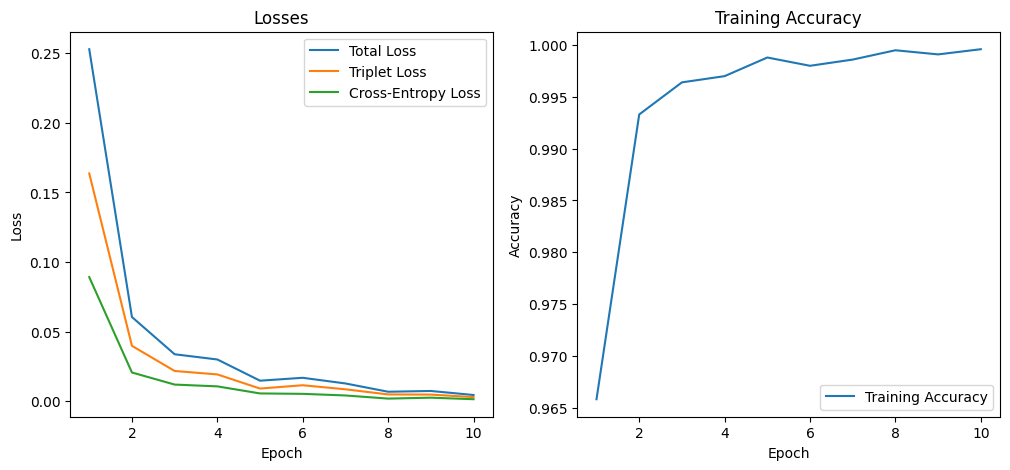

In [29]:
# Plot Losses and Accuracy
epochs = range(1, num_epochs+1)

plt.figure(figsize=(12, 5))

# Losses
plt.subplot(1, 2, 1)
plt.plot(epochs, total_losses_combined, label='Total Loss')
plt.plot(epochs, triplet_losses_combined, label='Triplet Loss')
plt.plot(epochs, cross_entropy_losses_combined, label='Cross-Entropy Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Losses')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies_combined, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.show()

(c) Calculating Final Accuracy on Test Dataset

In [30]:
def evaluate_combined_model(model, dataloader):
    model.eval()
    running_corrects = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            embeddings, outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            running_corrects += torch.sum(preds == labels.data)
            total += labels.size(0)

    accuracy = running_corrects.double() / total
    print('Test Accuracy: {:.4f}'.format(accuracy))
    return accuracy

test_accuracy_combined = evaluate_combined_model(model_combined, test_loader)

Test Accuracy: 0.9960


(d) Analysis of the Impact of Combining Criteria

By training the model with both triplet loss and cross-entropy loss simultaneously, the model learns more discriminative features while directly optimizing for classification accuracy. This can lead to improved performance and better generalization on the test dataset. The triplet loss helps the model to cluster similar embeddings together and push dissimilar ones apart, enhancing feature representation.